In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
def confidence_interval (data, rep=100, coeff=1.96): #default 95%
    data_avg=np.mean(data,axis=1)
    data_std=np.std(data,axis=1)
    max_val=data_avg+coeff*data_std/np.sqrt(rep)
    min_val=data_avg-coeff*data_std/np.sqrt(rep)
    return data_avg, data_std, max_val, min_val

def plot_confidence_interval (plt, data, x_axis, color):
    data_avg, data_std, max_val, min_val = confidence_interval (data)
    plt.fill_between(x_axis, data_avg, max_val, alpha=0.3, color=color)
    plt.fill_between(x_axis, min_val, data_avg, alpha=0.3, color=color)
    
def convert_label(label):
    load,buff_raw = label.split(" ")
    buff = buff_raw[0:-9]
    return [int(load),int(buff)]

def struct_data(data):
    structed_data = []
    index = 0
    while index < len(data)-1:
        if data[index]=='\n':
            flag = convert_label(data[index+1])
            index += 2
            while data[index]!='\n' and index<len(data)-1:
                structed_data.append(flag+data[index].split(" "))
                index += 1
    return np.array(structed_data)

In [69]:
# Read throuthput log file and convert to data frame
f = open("./logs/thr_sub_msg.txt",'r')
data = f.readlines()
f.close()
df_thr= pd.DataFrame(struct_data(data)[:,0:3], columns=["payload","sub_buff","throughput"]) 
df_thr["throughput"]=df_thr["throughput"].map(lambda e: float(e))
df_thr["payload"]=df_thr["payload"].map(lambda e: int(e))
df_thr["sub_buff"]=df_thr["sub_buff"].map(lambda e: int(e))
df_thr
# Read memory usage log file and convert to data frame
f = open("./logs/mem_sub_msg.txt",'r')
data = f.readlines()
f.close()
df_mem=pd.DataFrame(struct_data(data)[:,0:5], columns=["payload","sub_buff","total_mem","RSS","shared_mem"]) 
df_mem["payload"]=df_mem["payload"].map(lambda e: int(e))
df_mem["sub_buff"]=df_mem["sub_buff"].map(lambda e: int(e))
df_mem["total_mem"]=df_mem["total_mem"].map(lambda e: int(e)*4096)
df_mem["RSS"]=df_mem["RSS"].map(lambda e: int(e)*4096)
df_mem["shared_mem"]=df_mem["shared_mem"].map(lambda e: int(e)*4096)
df_mem

,payload,sub_buff,total_mem,RSS,shared_mem
0,8,64,495435776,6475776,5595136
1,8,64,495435776,6475776,5595136
2,8,64,495435776,8921088,5660672
3,8,64,495435776,11132928,5726208
4,8,64,495435776,11132928,5726208
...,...,...,...,...,...
4182,8192,512,495435776,6275072,5394432
4183,8192,512,495435776,6275072,5394432
4184,8192,512,495435776,6275072,5394432
4185,8192,512,495435776,6275072,5394432


([<matplotlib.axis.XTick at 0x7f5ac5491f50>,
 <a list of 10 Text xticklabel objects>)

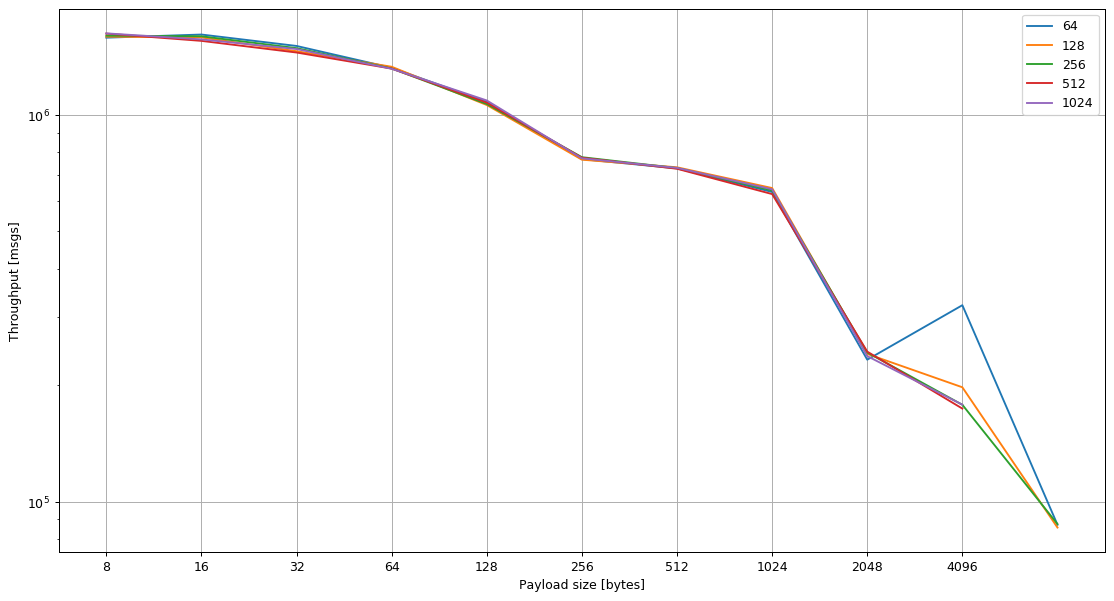

In [70]:
# Simple plot of throughtput
buff_group = df_thr.groupby(by=["sub_buff"])
plt.figure(figsize=(15,8),dpi=90)
x_real = []
for g_name,g_buff in buff_group: 
#     group128 = buff_group.get_group("128KiB")
    msg_group = g_buff.groupby(by="payload",sort=True)
    mean_thr = []
    x_real = []
    for name, group in msg_group:
            x_real.append(name)
            mean_thr.append(group.mean()["throughput"])

    plot_index = np.arange(len(mean_thr))

    plt.plot(plot_index,mean_thr,label=g_name)
plt.legend()
plt.grid()
plt.xlabel("Payload size [bytes]")
plt.ylabel("Throughput [msgs]")
plt.yscale("log")
plt.xticks(np.arange(len(x_real)),x_real)

[64, 128, 256, 512, 1024]


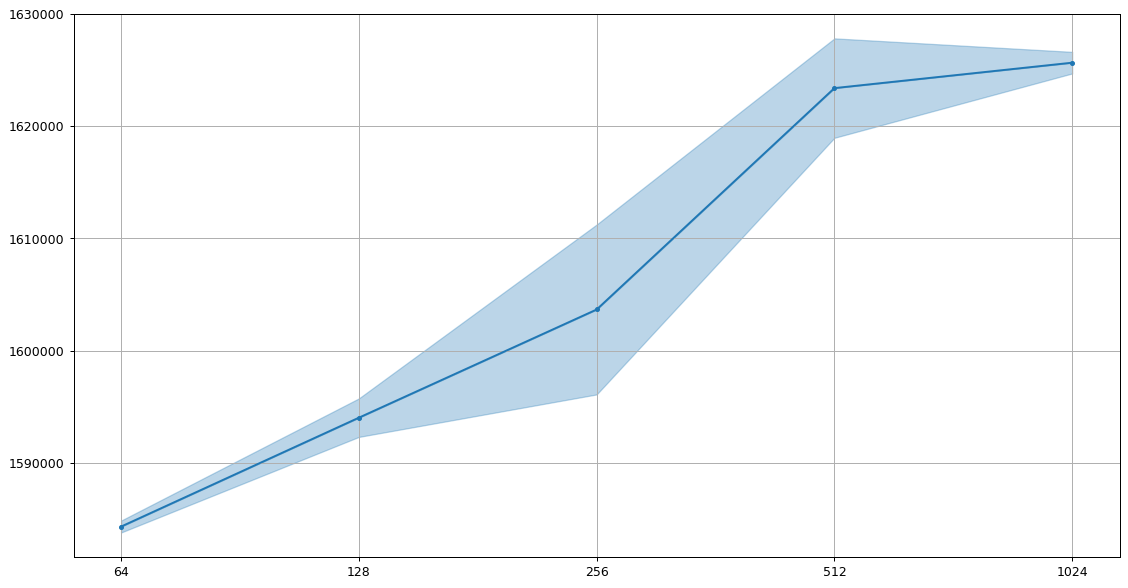

In [76]:
df_thr_payload=df_thr.groupby(by=["payload"])
g = df_thr_payload.get_group(8)

buff_group = []
buff_label = []

for label,group in g.groupby(by=["sub_buff"]):
    buff_label.append(label)
    buff_group.append(group["throughput"].tolist())

print(buff_label)

real_index= [0,1,2,3,4]


fig = plt.figure(figsize=(15,8),dpi=90)
plt.plot(real_index,np.mean(buff_group, axis=1), linestyle='-', marker='o', markersize=3, color='tab:blue')
plot_confidence_interval (plt, buff_group, real_index, "tab:blue")
plt.xticks(real_index,buff_label)
plt.grid()